# EDA

## 0. Imports

### 0.1 Function Imports

In [1]:
# Function imports
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns
import dask.dataframe as dd
import pandas as pd
from IPython.display import display, Markdown

from matplotlib.colors import LogNorm

# Sets style defaults
plt.style.use("petroff10")
sns.set_style("whitegrid")

### 0.2 File Imports

In [2]:
# Import data
df_games = pd.read_parquet("../../data/store_info.parquet")
df_genres = pd.read_parquet("../../data/genres.parquet")
df_categories = pd.read_parquet("../../data/categories.parquet")
ddf_reviews = dd.read_parquet("../../data/reviews.parquet/")
ddf_reviews["language"] = ddf_reviews["language"].astype("category")
df_reviews = ddf_reviews.compute()

## 1. Basic EDA

### 1.1 Recommendation Distribution
Steam uses "recommendation" to refer to positive reviews with or without text.
The steam unofficial API does not report recommendation counts below 100, so this graph starts at x=100.

We can see that lower recommendation counts are more common.

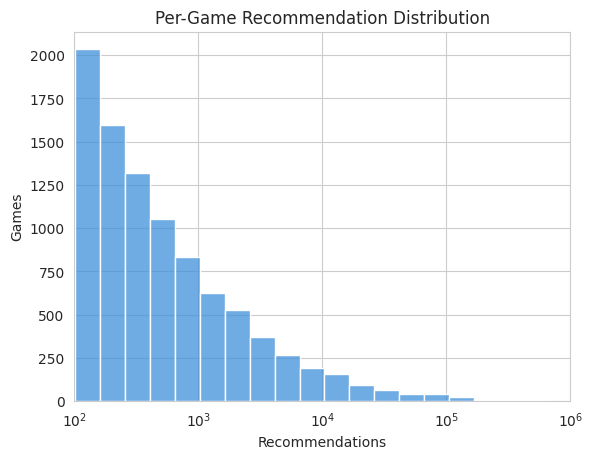

In [3]:
sns.histplot(df_games, x="recommendations", bins="doane", log_scale=(True, False))
plt.ylabel("Games")
plt.xlabel("Recommendations")
plt.xlim(10**2, 10**6)

plt.title("Per-Game Recommendation Distribution")
plt.show()

### 1.2 Review Distribution
Lower review counts are more common. This makes sense intuitively, and matches what we see for recommendations.

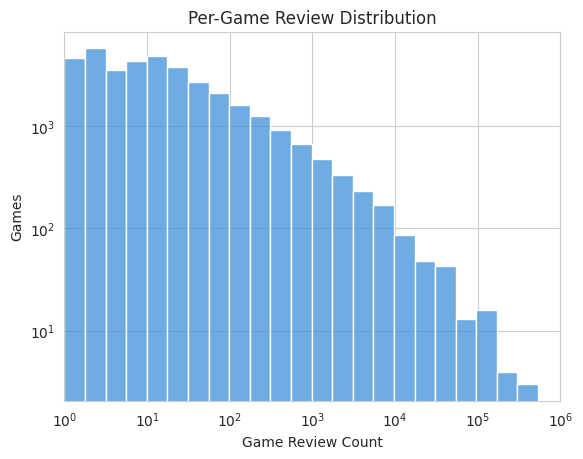

In [4]:
sns.histplot(
    df_reviews["steam_appid"].value_counts().reset_index(),
    x="count",
    bins="doane",
    log_scale=(True, False),
)
plt.ylabel("Games")
plt.xlabel("Game Review Count")
plt.xlim((1, 10**6))
plt.yscale('log')
plt.title("Per-Game Review Distribution")
plt.show()

### 1.3 Review Percent by Sentiment
Notably, the majority of reviews are positive.

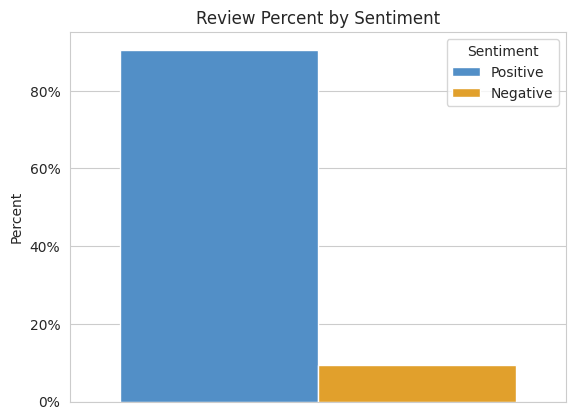

In [5]:
df_reviews['Sentiment'] = df_reviews['voted_up'].replace([True,False],['Positive','Negative']).astype('category')

sns.countplot(
    df_reviews,

    x=np.zeros(len(df_reviews)),

    hue="Sentiment",
    hue_order=["Positive","Negative"],
    stat="percent",
)

plt.ylabel('Percent')
plt.gca().yaxis.set_major_formatter(PercentFormatter())
plt.gca().xaxis.set_visible(False)
plt.title("Review Percent by Sentiment")
plt.show()

### 1.5 Games per Review Count & Positivity
The figure below illustrates how games are distributed relative to their review counts and the percentage of those reviews which are positive (the "positivity percent").

The main takeaways are:
- Lower review counts/positivity percents are much more common
- Games with more than 10,000 reviews have positivity percents <= 99%
- Games with more than 10,000 reviews are more likely to have positivity percents >= 90%

(A more complete but slightly less legible version of this figure is included in the appendix)

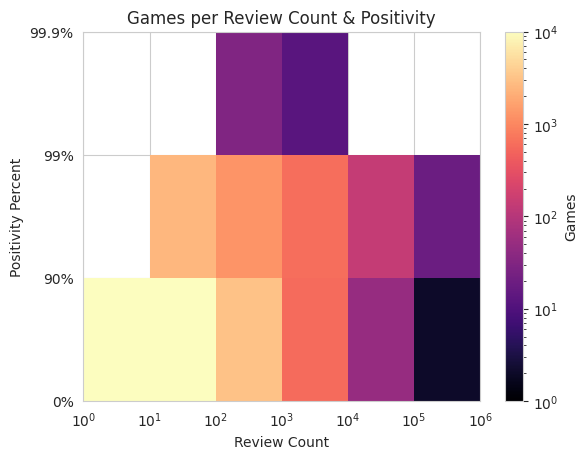

In [6]:
df_positivity = df_reviews[['steam_appid','voted_up']].copy()
df_positivity['voted_up'] = df_positivity['voted_up'].astype(int)
df_positivity = df_positivity.groupby('steam_appid')['voted_up'].describe()

plt.hist2d(
    x=df_positivity["count"],
    y=1/(1-df_positivity["mean"]),
    range=((1,10**6),(1,10**3)),
    bins=(np.logspace(0,6,num=7),np.logspace(0,3,num=4)),
    norm=LogNorm(vmin=10**0,vmax=10**4),
    cmap='magma'
)

plt.xscale('log')
plt.yscale('log')
plt.yticks([1,10,100,1000],["0%","90%","99%","99.9%"])
plt.colorbar(label="Games")
plt.ylabel('Positivity Percent')
plt.xlabel('Review Count')
plt.title('Games per Review Count & Positivity')
plt.show()

### 1.6 Games with 100% Positvity per Review Count
The figure below shows how many games have 100% positive reviews at different review counts.

Unsurprisingly, it is exceedingly unlikely for a game with more than 100 reviews to have 100% positivity, and no games with more than 1000 reviews has 100% positivity.

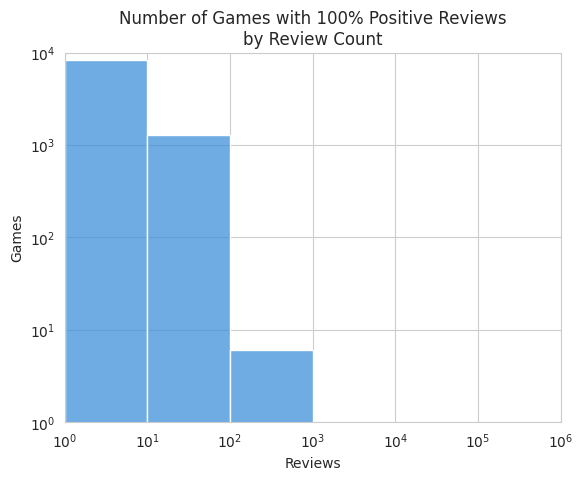

In [7]:
sns.histplot(df_positivity[df_positivity['mean'] == 1]['count'],
             log_scale=(True,False),
             binrange=(0,6),
             bins=6)
plt.xlim((1,10**6))
plt.ylim((1,10**4))
plt.yscale('log')
plt.title('Number of Games with 100% Positive Reviews\nby Review Count')
plt.ylabel('Games')
plt.xlabel('Reviews')
plt.show()

## 2. Intermediate EDA - Categorical Features

In [8]:
df_genres[df_genres['Indie'] == False]

,360 Video,Accounting,Action,Adventure,Animation & Modeling,Audio Production,Casual,Design & Illustration,Documentary,Early Access,...,Short,Simulation,Software Training,Sports,Strategy,Tutorial,Utilities,Video Production,Violent,Web Publishing
steam_appid,,,,,,,,,,,,,,,,,,,,,
1000860,False,False,True,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
1002280,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1004550,False,False,True,False,False,False,True,False,False,False,...,False,True,False,False,False,False,False,False,False,False
1008830,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1009200,False,False,True,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995850,False,False,False,True,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
995980,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
997060,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


### 2.1 Game Genre Breakdown
The table below shows how many games present are in each genre. Genres are not mutually exclusive.
I don't intend to use these for the recommender system (I think user-assigned tags will be more valuable), but it is interesting to see how games describe themselves. Only a few of these genre apply to 10% of games or more.

Notably, the "Indie" tag (which should apply to all games in this dataset) is missing from some 5% of games, suggesting that these genre assignments are not totally reliable.

In [9]:
# Gets game counts per genre tag
df_genre_counts = (
    pd.DataFrame(df_genres.sum())
    .rename(columns={0: "Count"})
    .sort_values("Count", ascending=False)
)

# Converts game counts to percentages (of all games)
df_genre_counts["Percent"] = df_genre_counts["Count"] / len(df_genres) * 100

df_genre_counts.style.background_gradient(
    cmap="magma", gmap=np.log10(df_genre_counts["Count"]), vmax=np.log10(len(df_games))
).format(precision=0, thousands=",")

,Count,Percent
Indie,"55,794",95
Casual,"25,836",44
Action,"24,907",43
Adventure,"23,270",40
Simulation,"10,690",18
Strategy,"10,580",18
RPG,"9,901",17
Early Access,"5,767",10
Free To Play,"4,684",8
Sports,"2,222",4


### 2.2 Game Compatibility Breakdown
Hardware/Software compatibility shouldn't necessarily "inform" the recommender system, but it's still interesting to see which features are common amongst indie games. Here are the things that stand out to me:
- Almost all (96%) of indie games can be played in Single-Player, and only 16% have some kind of multiplayer support.
- PVP (competitive multiplayer, 10%) is slightly more common than co-op (collaborative multiplayer, 8%)
- About a third of games (37%) lack controller support
- Fewer than 200 indie games have VR support 

In [10]:
# Same as above but for hardware/software compatibility
df_category_counts = (
    pd.DataFrame(df_categories.sum())
    .rename(columns={0: "Count"})
    .sort_values("Count", ascending=False)
)
df_category_counts["Percent"] = df_category_counts["Count"] / len(df_categories) * 100
df_category_counts.style.background_gradient(
    cmap="magma", gmap=np.log10(df_category_counts["Count"]), vmax=np.log10(len(df_games))
).format(
    precision=0,
    thousands=","
)

,Count,Percent
Single-player,"56,243",96
Family Sharing,"44,764",77
Steam Achievements,"28,944",50
Steam Cloud,"14,172",24
Full controller support,"13,821",24
Multi-player,"9,377",16
Partial Controller Support,"7,646",13
Steam Trading Cards,"7,008",12
PvP,"6,028",10
Steam Leaderboards,"5,317",9


## 3. Intermediate EDA - Quantitative Features

### 3.1 Reviews per Author
The number of reviews per author appears to follow an exponential distribution. This will be important for the review graph, as it will relate to the graph interconnectivity.

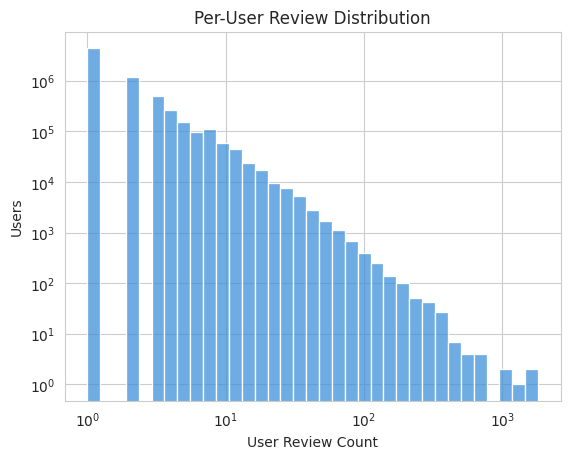

In [11]:
# Calculates/plots reviews-per-author
df_reviews_per_author = pd.DataFrame(
    ddf_reviews["author_steamid"].value_counts().compute()
)

sns.histplot(df_reviews_per_author, x="count", bins="doane", log_scale=(True, False))
plt.yscale("log")
plt.ylabel("Users")
plt.xlabel("User Review Count")
plt.title("Per-User Review Distribution")
plt.show()

### 3.2 Author playtime at review
Ideally, I could identify a variable to serve as the edge weight in the review graph; this feature would correlate with a reviewer's enjoyment of the game. Because reviews are only positive or negative, it is impossible to find a feature related to sentiment magnitude (i.e., how _much_ a user liked/disliked a game), but it may be possible find one that reasonably predicts whether they enjoyed it.

The first feature that comes to mind is playtime at review. It does look like negative reviews tend to be associated with lower playtimes, but there's too broad a range of playtimes for both review sentiments, resulting in considerable overlap. At least some of this variability comes from the games themselves being shorter/longer than each other, but it's also likely that some people need more/less time with a game to decide whether they like it.

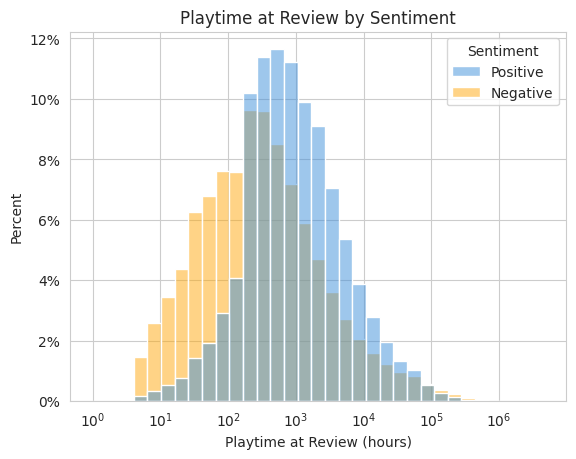

In [12]:
sns.histplot(
    df_reviews,
    x="author_playtime_at_review",
    hue="Sentiment",
    bins="doane",
    stat="percent",
    hue_order=["Positive", "Negative"],
    common_norm=False,
    log_scale=(True, False),
)

plt.title("Playtime at Review by Sentiment")
plt.xlabel("Playtime at Review (hours)")
plt.gca().yaxis.set_major_formatter(PercentFormatter(decimals=0))
plt.show()

### 3.3 Absolute Playtime Since Review
I also thought it might be useful to see how much users play games after they review them (surely, people who didn't like a game wouldn't return to it?), but there's still a lot of overlap between positive and negative reviews.

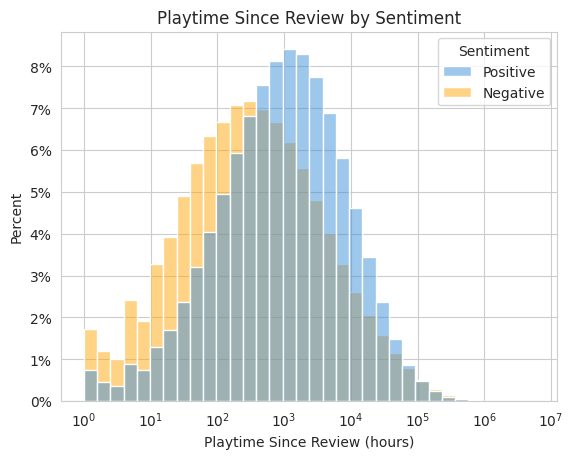

In [13]:
df_reviews["author_playtime_since_review"] = (
    df_reviews["author_playtime_forever"] - df_reviews["author_playtime_at_review"]
)

sns.histplot(
    df_reviews,
    x="author_playtime_since_review",
    hue="Sentiment",
    bins="doane",
    stat="percent",
    hue_order=["Positive", "Negative"],
    common_norm=False,
    log_scale=(True, False),
)
plt.gca().yaxis.set_major_formatter(PercentFormatter(decimals=0))
plt.xlabel('Playtime Since Review (hours)')
plt.title("Playtime Since Review by Sentiment")
plt.show()

### 3.4 Was Game Abandoned Since Review
A simpler metric for enjoyment might be whether or not the user abandoned the game after writing the review. A small fraction (15%) of positive reviews come from users who never returned to those games (perhaps because they'd completed the game before reviewing it), but almost half of users who left negative reviews later returned to those games.

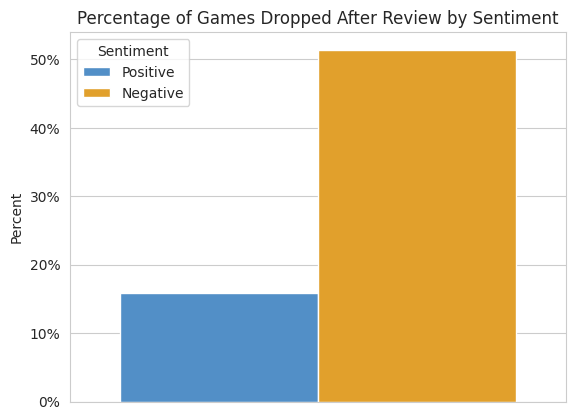

In [ ]:
df_reviews['game_dropped'] = df_reviews['author_playtime_since_review'] <= 0
df_games_dropped = df_reviews[['game_dropped','Sentiment']].groupby('Sentiment').value_counts(normalize=True).reset_index()
df_games_dropped = df_games_dropped[df_games_dropped["game_dropped"]]
sns.barplot(df_games_dropped,
            y='proportion',
            hue='Sentiment',
            hue_order=['Positive','Negative'])
plt.ylabel('Percent')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.title('Percentage of Games Abandoned After Review by Sentiment')
plt.show()

## 4. Advanced EDA

### 4.1 Per-Game Playtime by Review Sentiment
The graphs below visualize game playtimes at review for different games, colored by review sentiment. From left to right, the graphs are meant to convey
1. The distribution of playtimes at review
2. A comparison of the distributions of playtimes per-sentiment
3. The proportion of playtimes attributable to a particular sentiment.

We can see that there isn't always a strictly monotonic relationship between playtime and review positivity probability... it may not be possible to try and make sense of these numbers.

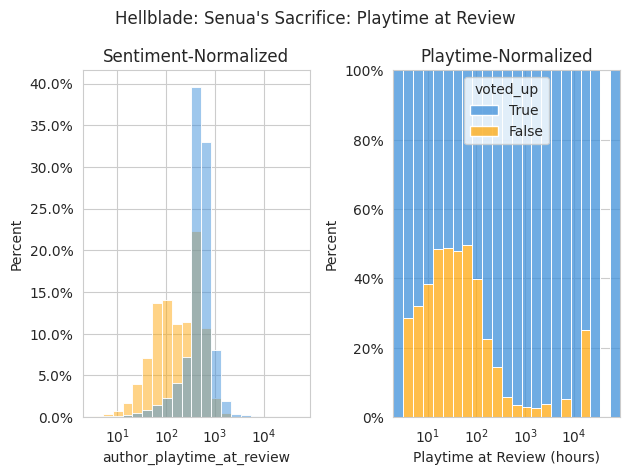

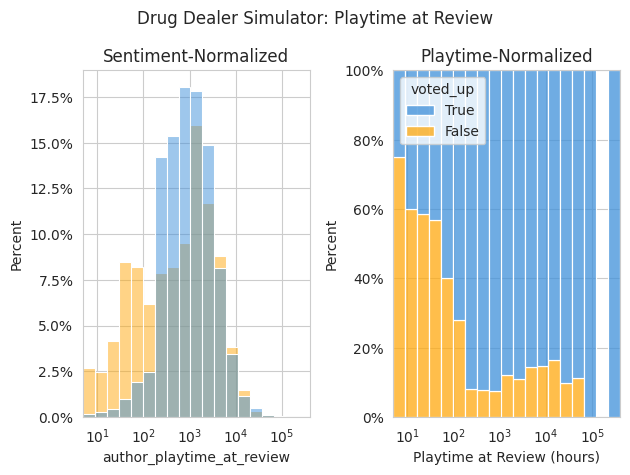

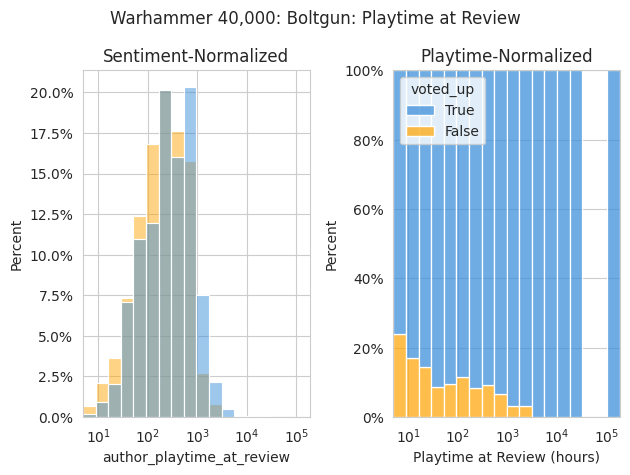

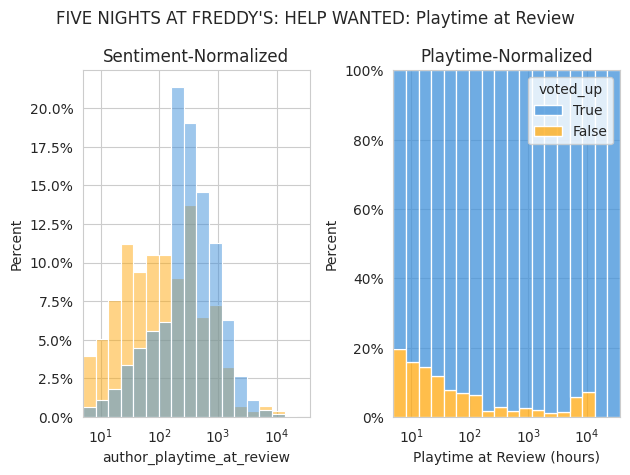

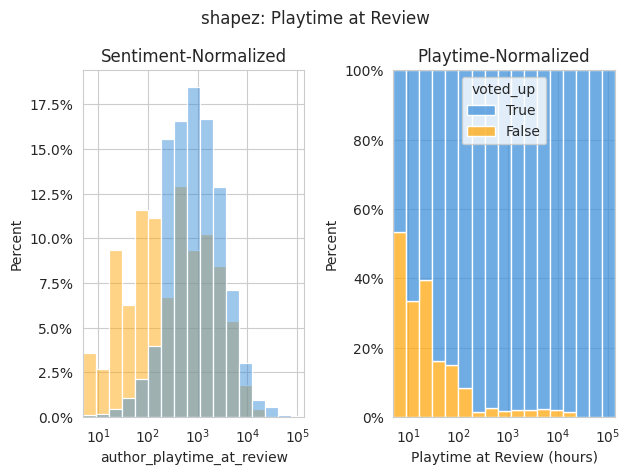

In [ ]:
for appid in (
    df_games[df_games["recommendations"] > 10000].sample(5, random_state=42).index
):
    fig, ax = plt.subplots(ncols=2, nrows=1, sharex=True)
    sns.histplot(
        df_reviews[df_reviews["steam_appid"] == appid],
        x="author_playtime_at_review",
        hue="voted_up",
        hue_order=[True, False],
        bins="doane",
        stat="percent",
        common_norm=False,
        log_scale=(True, False),
        ax=ax[0],
    )
    
    sns.histplot(
        df_reviews[df_reviews["steam_appid"] == appid],
        x="author_playtime_at_review",
        hue="voted_up",
        
        hue_order=[True, False],
        bins="doane",
        stat="proportion",
        common_norm=True,
        multiple='fill',
        log_scale=(True, False),
        ax=ax[1],
    )
        
    ax[0].yaxis.set_major_formatter(PercentFormatter())
    ax[1].yaxis.set_major_formatter(PercentFormatter(1))
    ax[0].get_legend().remove()
    ax[0].set_title("Sentiment-Normalized")
    ax[1].set_ylabel("Percent")
    ax[1].set_title("Playtime-Normalized")
    plt.xlabel("Playtime at Review (hours)")
    fig.suptitle(f'{df_games.loc[appid, "name"]}: Playtime at Review')
    plt.tight_layout()
    plt.show()

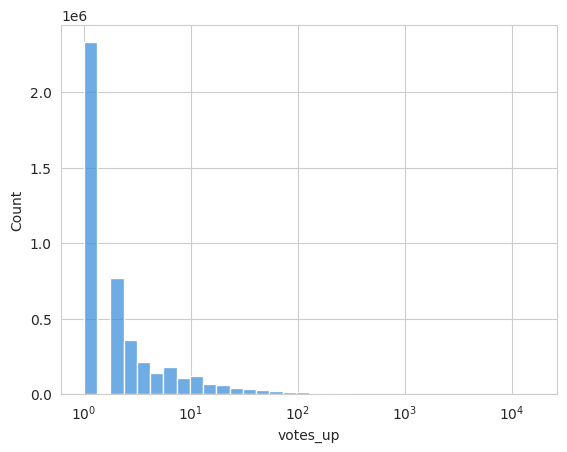

In [47]:
sns.histplot(df_reviews['votes_up'],
             log_scale=(True,False),
             bins='doane')
plt.show()

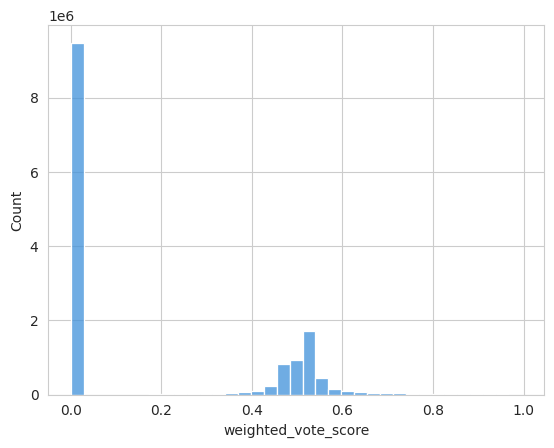

In [48]:
sns.histplot(df_reviews['weighted_vote_score'],
             bins='doane')
plt.show()

In [202]:
df_positivity_table = pd.DataFrame()
df_positivity_table["Review Count"] = pd.cut(
    df_positivity["count"],
    bins=np.concatenate((np.zeros(1), np.logspace(0, 6, 7))),
    labels=[
        "(0, 1]",
        "(1, 10]",
        "(10, 100]",
        "(100, 1,000]",
        "(1,000, 10,000]",
        "(10,000, 100,000]",
        "(100,000, 1,000,000]",
    ],
)

df_positivity_table["Review Positivity"] = pd.cut(
    df_positivity["mean"] * 100,
    bins=[0, 90, 99, 99.9, 100],
    labels=["(0%, 90%]", "(90%, 99%]", "(99%, 99.9%]", "(99.9%, 100%]"],
)

df_positivity_table = pd.pivot_table(
    pd.DataFrame(df_positivity_table.value_counts().reset_index()),
    index="Review Count",
    columns="Review Positivity",
    values="count",
    observed=False,
    fill_value=0,
    dropna=False,
).astype(int)

display(Markdown("### Games per Review Count/Positivity (Right-Bound inclusive)"))
display(
    df_positivity_table.style.background_gradient(
        gmap=np.log10(df_positivity_table + 1), axis=None, cmap="magma"
    )
)

### Games per Review Count/Positivity (Right-Bound inclusive)

Review Positivity,"(0%, 90%]","(90%, 99%]","(99%, 99.9%]","(99.9%, 100%]"
Review Count,,,,
"(0, 1]",0,0,0,3083
"(1, 10]",8177,0,0,5448
"(10, 100]",9291,2288,0,1081
"(100, 1,000]",3127,1254,30,5
"(1,000, 10,000]",570,608,12,0
"(10,000, 100,000]",49,137,0,0
"(100,000, 1,000,000]",2,19,0,0
